In [9]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [70]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_blkplus2_cav1cy2_goodparams_analyse/'

In [71]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[],
           "Manual ECM spots mask":[],
           "Manual endosome spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("posthoc" in str(filelist[i]))==False:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["endosomechannelno"].append(endosomechannelno)
                                        

In [72]:
results["filename"]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_blkplus2_cav1cy2_goodparams_analyse/20190522_tnr550_blkplus2_cav1cy2_goodparams/20190522_tnr550_blkplus2_cav1cy2_goodparams_Series7_z',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_blkplus2_cav1cy2_goodparams_analyse/20190522_tnr550_blkplus2_cav1cy2_goodparams/20190522_tnr550_blkplus2_cav1cy2_goodparams_Series6_z',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_blkplus2_cav1cy2_goodparams_analyse/20190522_tnr550_blkplus2_cav1cy2_goodparams/20190522_tnr550_blkplus2_cav1cy2_goodparams_Series5_z',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr550_blkplus2_cav1cy2_goodparams_analyse/20190522_tnr550_blkplus2_cav1cy2_goodparams/20190522_tnr550_blkplus2_cav1cy2_goodparams_Series4_z',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190522_tnr

In [63]:
results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/20190612_tnr647_blkplus12_tgn38acy2_analyse/20190612_tnr647_blkplus12_tgn38acy2/20190612_tnr647_blkplus12_tgn38acy2_Series6_z0_ch1_t0.tif'

## Loading a random image

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: 20190612_tnr647_blkplus12_tgn38acy2_Series3_z
Experimental condition: 20190612_tnr647_blkplus12_tgn38acy2


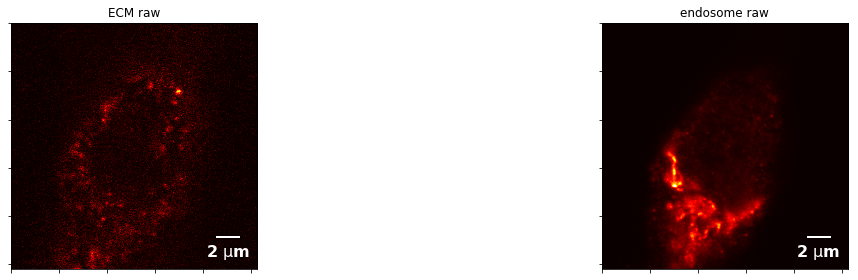

In [64]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]
#synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
#synapse_image_name=results["filename"][randomno]+"0_ch"+str(synapse_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
#synapse_image=pims.open(synapse_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
#figure.add_subplot(132)
#plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
#plt.title('ECM scaled')
#plt.grid(visible=False)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
#scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
 #                      font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
#plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Find spots

### Manual

In [75]:
#make empty masks
for i in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.nan)
    results["Manual endosome spots mask"].append(np.nan)

In [76]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
ecm_channel_no=results["ecmchannelno"][first]
ecm_image_name=results["filename"][first]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
ecm_image=pims.open(ecm_image_name)[0]
ecm_spots=deepcopy(ecm_image)
ecm_spots=ndi.median_filter(ecm_spots,size=5)

lower_man_threshold=np.min(ecm_spots)
upper_man_threshold=np.max(ecm_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    ecm_channel_no=results["ecmchannelno"][ii]
    ecm_image_name=results["filename"][ii]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(ecm_image, 3)
    #ecm_image = ecm_image - lowpass
    #ecm_image[ecm_image<0]=0
    
    ecm_spots=deepcopy(ecm_image)
    lower_man_threshold=np.min(ecm_spots)
    upper_man_threshold=np.max(ecm_spots)

    if Threshold=="Li":
        ecm_image_threshold=threshold_li(ecm_image)      
    if Threshold=="Otsu":
        ecm_image_threshold=threshold_otsu(ecm_image)
    if Threshold=="Manual":
        ecm_image_threshold=Manual_Threshold
    
    ecm_spots[ecm_spots<ecm_image_threshold]=0
    ecm_spots=ndi.binary_opening(ecm_spots,iterations=Open)
    ecm_spots=ndi.binary_closing(ecm_spots,iterations=Close)
    results["Manual ECM spots mask"][ii]=ecm_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(ecm_spots)
    plt.imshow(ecm_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(ecm_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

### Backup manual spots for ecm

In [77]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_ecm_spots_mask.npy',results["Manual ECM spots mask"][image])

### Make spots for endosome channel

In [78]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
endosome_channel_no=results["endosomechannelno"][first]
endosome_image_name=results["filename"][first]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
endosome_image=pims.open(endosome_image_name)[0]
endosome_spots=deepcopy(endosome_image)
endosome_spots=ndi.median_filter(endosome_spots,size=5)

lower_man_threshold=np.min(endosome_spots)
upper_man_threshold=np.max(endosome_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    endosome_channel_no=results["endosomechannelno"][ii]
    endosome_image_name=results["filename"][ii]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    endosome_image=pims.open(endosome_image_name)[0]
    #bandpass (subtract gaussian filter)
    #lowpass = ndi.gaussian_filter(endosome_image, 3)
    #endosome_image = endosome_image - lowpass
    #endosome_image[endosome_image<0]=0
    
    endosome_spots=deepcopy(endosome_image)
    lower_man_threshold=np.min(endosome_spots)
    upper_man_threshold=np.max(endosome_spots)

    if Threshold=="Li":
        endosome_image_threshold=threshold_li(endosome_image)      
    if Threshold=="Otsu":
        endosome_image_threshold=threshold_otsu(endosome_image)
    if Threshold=="Manual":
        endosome_image_threshold=Manual_Threshold
    
    endosome_spots[endosome_spots<endosome_image_threshold]=0
    endosome_spots=ndi.binary_opening(endosome_spots,iterations=Open)
    endosome_spots=ndi.binary_closing(endosome_spots,iterations=Close)
    results["Manual endosome spots mask"][ii]=endosome_spots
    fig=plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.imshow(endosome_spots)
    plt.imshow(endosome_image,alpha=0.5,cmap='inferno')
    fig.add_subplot(122)
    plt.imshow(endosome_image,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

In [79]:
for image in range(0,len(results["filename"])):
    np.save(results["filename"][image]+'_endosome_spots_mask.npy',results["Manual endosome spots mask"][image])